In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow.keras.layers.rnn")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/24-2/시계열분석/temp_seoul.csv")

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.index = df.index.tz_localize("UTC")
df.index = df.index.tz_convert("Asia/Seoul")

df = df[df.index.year == 2023]
df.temp = df.temp.interpolate(method='linear')

<ipython-input-3-5ef8bdf407a7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.temp = df.temp.interpolate(method='linear')


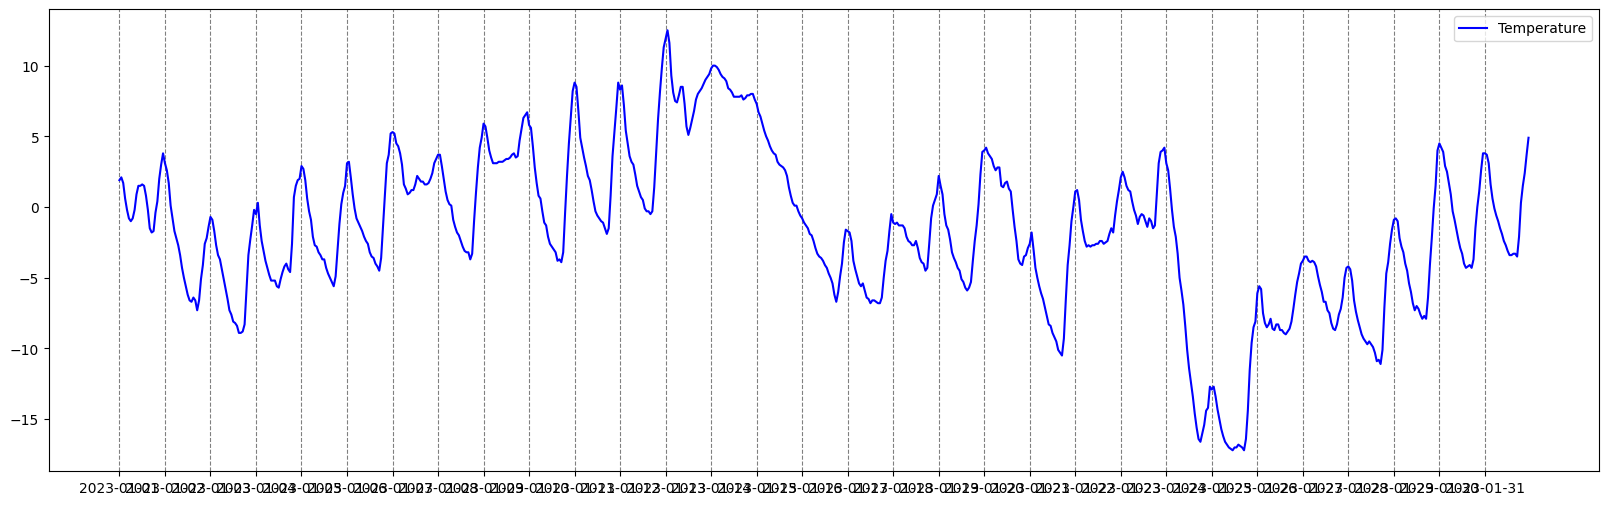

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(df.iloc[:24*31,:].index, df.iloc[:24*31,:].temp, label='Temperature', color='blue')

xticks = df.iloc[:24*31,:].index[::24]  # 인덱스에서 24 간격으로 선택
plt.xticks(xticks)
plt.grid(which='major', axis='x', linestyle='--', color='grey')

plt.legend()
plt.show()

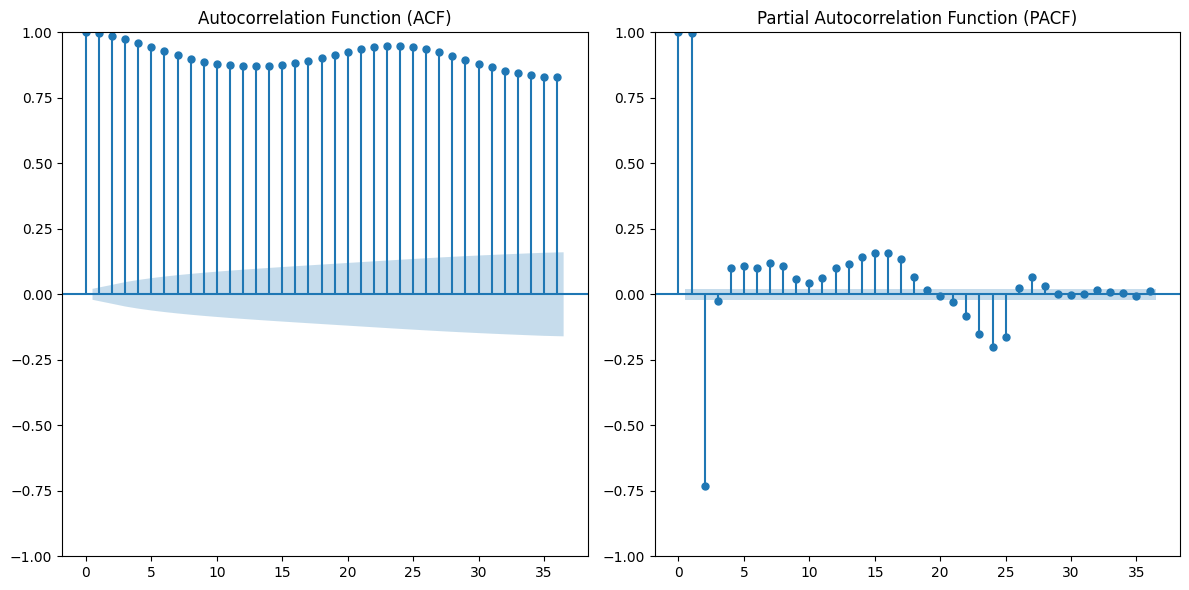

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df['temp'], lags=36, ax=plt.gca())  # 최대 36 lag까지 표시
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(df['temp'], lags=36, ax=plt.gca(), method='ywm')  # Partial ACF
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

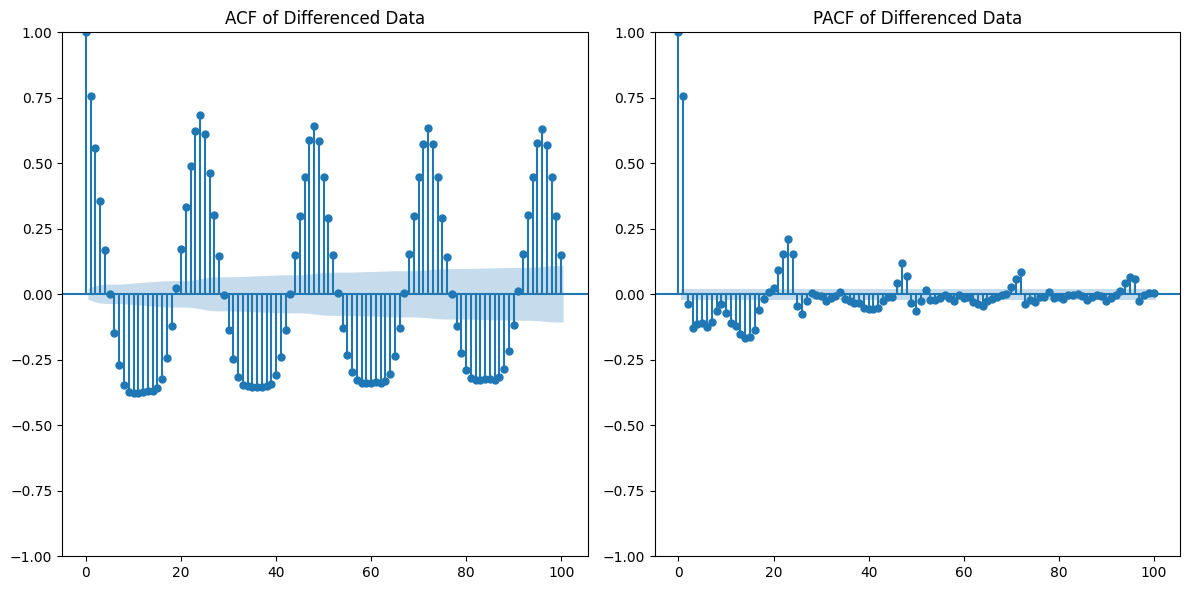

In [ ]:
df['temp_diff'] = df['temp'].diff()  # 1차 차분
diff_series = df['temp_diff'].dropna()  # 첫 번째 값이 NaN이므로 제거

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=100, ax=plt.gca())  # 최대 36 lag까지 표시
plt.title("ACF of Differenced Data")

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=100, ax=plt.gca(), method='ywm')
plt.title("PACF of Differenced Data")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(3,1,1)(2,0,0)[24] intercept   : AIC=3658.529, Time=22.94 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=6862.697, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3959.358, Time=5.45 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=5393.392, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6860.816, Time=0.07 sec
 ARIMA(3,1,1)(1,0,0)[24] intercept   : AIC=3942.673, Time=4.30 sec
 ARIMA(2,1,1)(2,0,0)[24] intercept   : AIC=3657.075, Time=16.69 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=3944.240, Time=4.32 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=3662.998, Time=11.50 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=13.39 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=3690.656, Time=11.65 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=16.56 sec
 ARIMA(2,1,1)(2,0,0)[24]             : AIC=3655.078, Time=5.41 sec
 ARIMA(2,1,1)(1,0,0)[24]             : AIC=3942.261, Time=3.16 sec
 ARIMA(1,1,1)(2,0,0)[24

<ipython-input-7-c5db25afda2f>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=temp_series.index[-1] + pd.Timedelta(hours=1), periods=n_periods, freq="H")


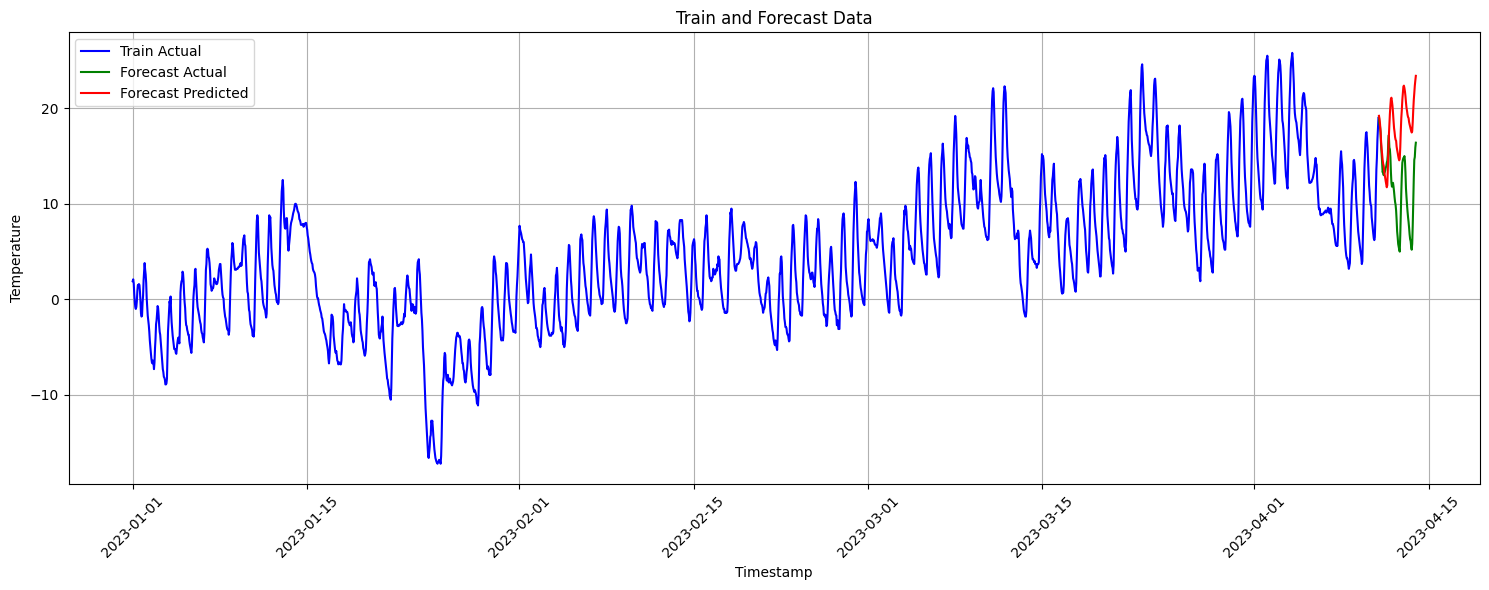

In [ ]:
temp_series = df.iloc[:24*100,:].temp
model = auto_arima(
    temp_series,
    seasonal=True,
    m=24,
    start_p=3, max_p=3,
    d=1,
    start_q=1, max_q=1,
    start_P=2, max_P=2,
    start_Q=0, max_Q=0,
    maxiter=12,
    trace=True,
    stepwise=True,
    n_jobs=-1,
    suppress_warnings=True
)
print(model.summary())

n_periods = 24*3
forecast = model.predict(n_periods=n_periods)
forecast_index = pd.date_range(start=temp_series.index[-1] + pd.Timedelta(hours=1), periods=n_periods, freq="H")
actual_data = df.loc[forecast_index, "temp"] if forecast_index[-1] in df.index else df.loc[forecast_index[:-1], "temp"]
train_df = temp_series.to_frame(name="Actual")
forecast_df = pd.DataFrame({
    "Timestamp": forecast_index,
    "Actual": actual_data.values,
    "Forecast": forecast
})
forecast_df.set_index("Timestamp", inplace=True)
combined_df = pd.concat([train_df, forecast_df], axis=0)

plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df["Actual"], label="Train Actual", color="blue", linestyle="-")
plt.plot(forecast_df.index, forecast_df["Actual"], label="Forecast Actual", color="green", linestyle="-")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast Predicted", color="red", linestyle="-")
plt.legend()
plt.grid()
plt.title("Train and Forecast Data")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

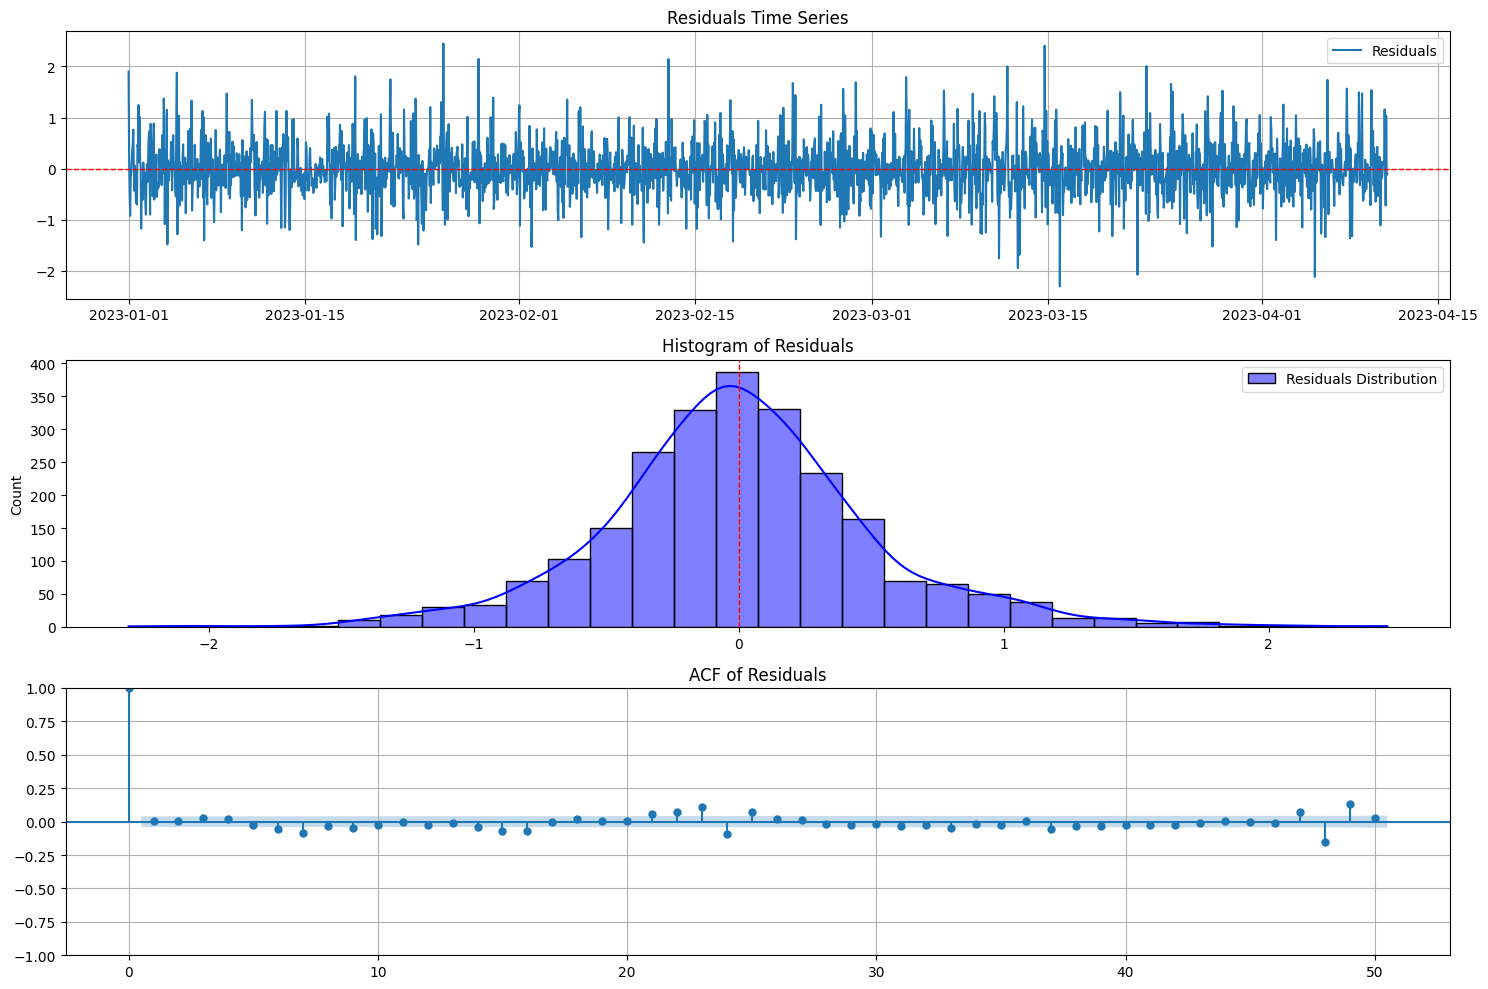

Shapiro-Wilk Test: Test Statistic = 0.9784, p-value = 0.0000

Ljung-Box Test Results:
    lb_stat  lb_pvalue
1  0.018941   0.890535
2  0.056599   0.972097


In [ ]:
residuals = temp_series - model.predict_in_sample()

plt.subplot(3, 1, 1)
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.title("Residuals Time Series")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
sns.histplot(residuals, kde=True, bins=30, color='blue', label="Residuals Distribution")
plt.axvline(x=residuals.mean(), color='r', linestyle='--', linewidth=1)
plt.title("Histogram of Residuals")
plt.legend()

plt.subplot(3, 1, 3)
plot_acf(residuals.dropna(), lags=50, ax=plt.gca())
plt.title("ACF of Residuals")
plt.grid()
plt.tight_layout()
plt.show()

shapiro_test_stat, shapiro_p_value = shapiro(residuals.dropna())
print(f"Shapiro-Wilk Test: Test Statistic = {shapiro_test_stat:.4f}, p-value = {shapiro_p_value:.4f}")
ljungbox_results = acorr_ljungbox(residuals.dropna(), lags=[1, 2], return_df=True)
print("\nLjung-Box Test Results:")
print(ljungbox_results)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def sarimax_forecast(train, order, seasonal_order):
    sarima_model = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order
    )
    sarima_fit = sarima_model.fit(disp=False)
    forecast = sarima_fit.forecast(steps=24)
    return forecast, sarima_fit.aic

def lstm_forecast(train, test, sequence_length=24):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.reshape(-1, 1))

    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len * 6):
            X.append(data[i : i + seq_len * 5])
            y.append(data[i + seq_len * 5 : i + seq_len * 6])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled, sequence_length)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=False),
        Dense(sequence_length)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

    test_scaled = scaler.transform(test.reshape(-1, 1))
    X_test = []
    X_test.append(test_scaled[: sequence_length * 5])
    X_test = np.array(X_test).reshape(1, sequence_length * 5, 1)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_pred

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Month 1 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 7.66 | AIC: 1100.99
  SARIMA (2,1,1)(2,0,0,24) - MSE: 7.53 | AIC: 1102.84
  LSTM                     - MSE: 3.49


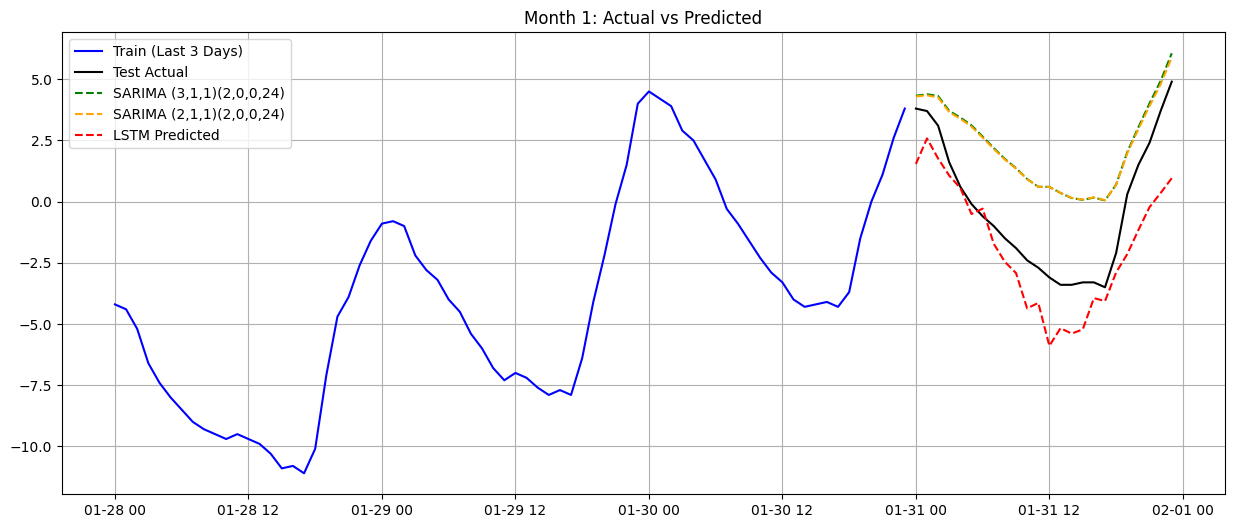

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

Month 2 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 27.45 | AIC: 904.32
  SARIMA (2,1,1)(2,0,0,24) - MSE: 27.08 | AIC: 902.86
  LSTM                     - MSE: 0.98


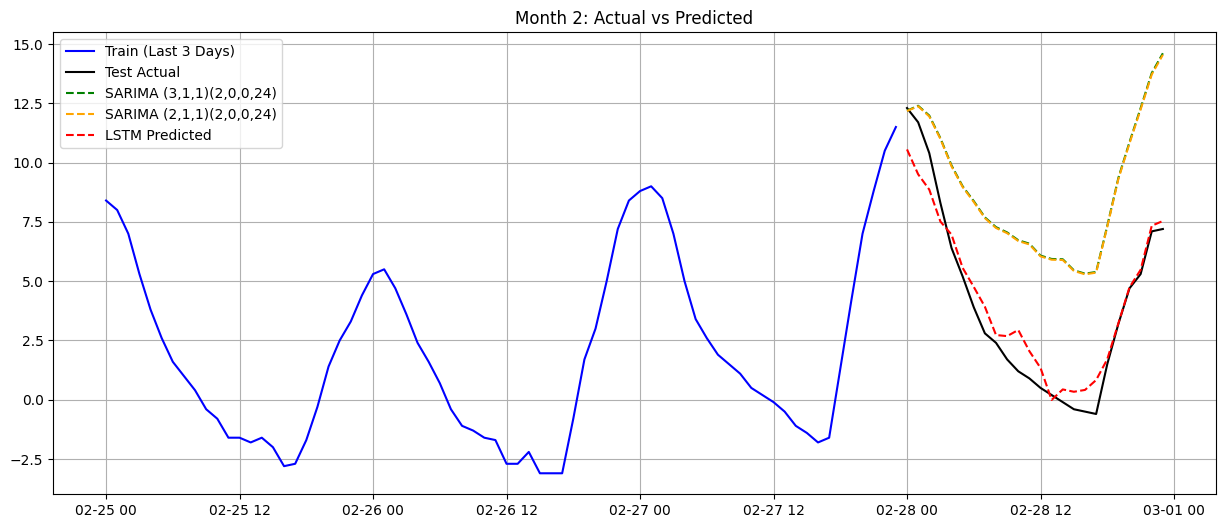

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Month 3 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 6.46 | AIC: 1191.64
  SARIMA (2,1,1)(2,0,0,24) - MSE: 11.34 | AIC: 1210.36
  LSTM                     - MSE: 3.57


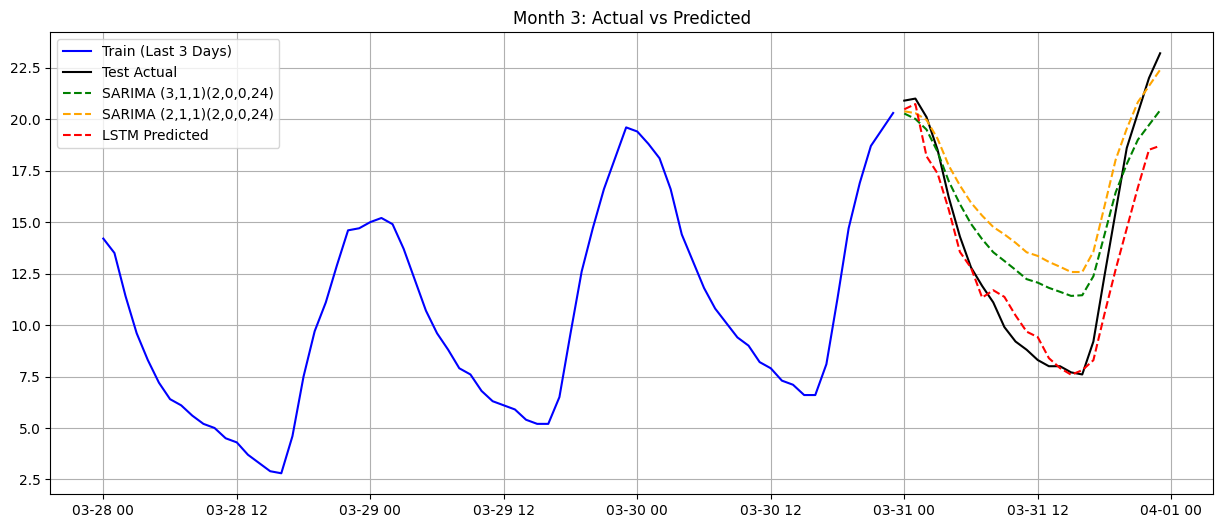

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Month 4 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 17.98 | AIC: 1225.54
  SARIMA (2,1,1)(2,0,0,24) - MSE: 15.39 | AIC: 1277.52
  LSTM                     - MSE: 13.11


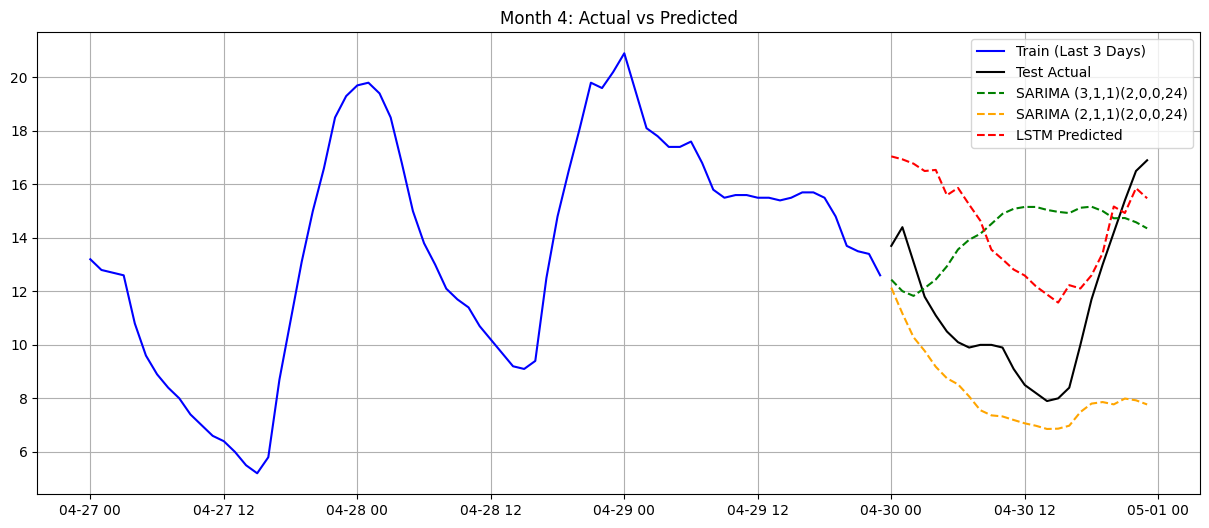

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Month 5 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 20.62 | AIC: 1251.62
  SARIMA (2,1,1)(2,0,0,24) - MSE: 20.62 | AIC: 1249.63
  LSTM                     - MSE: 1.87


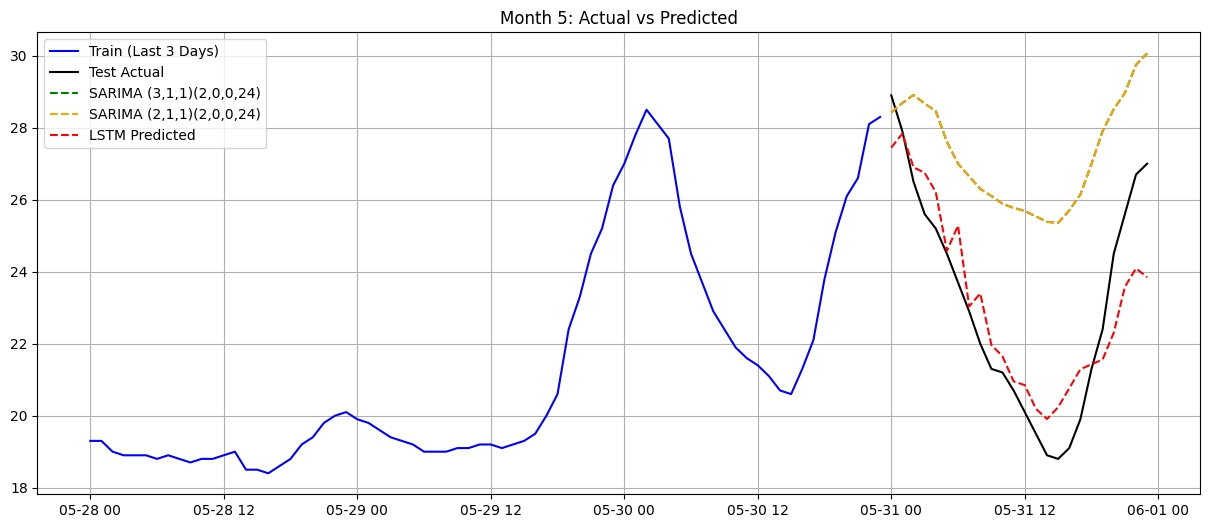

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Month 6 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 2.21 | AIC: 1126.21
  SARIMA (2,1,1)(2,0,0,24) - MSE: 1.76 | AIC: 1166.22
  LSTM                     - MSE: 3.10


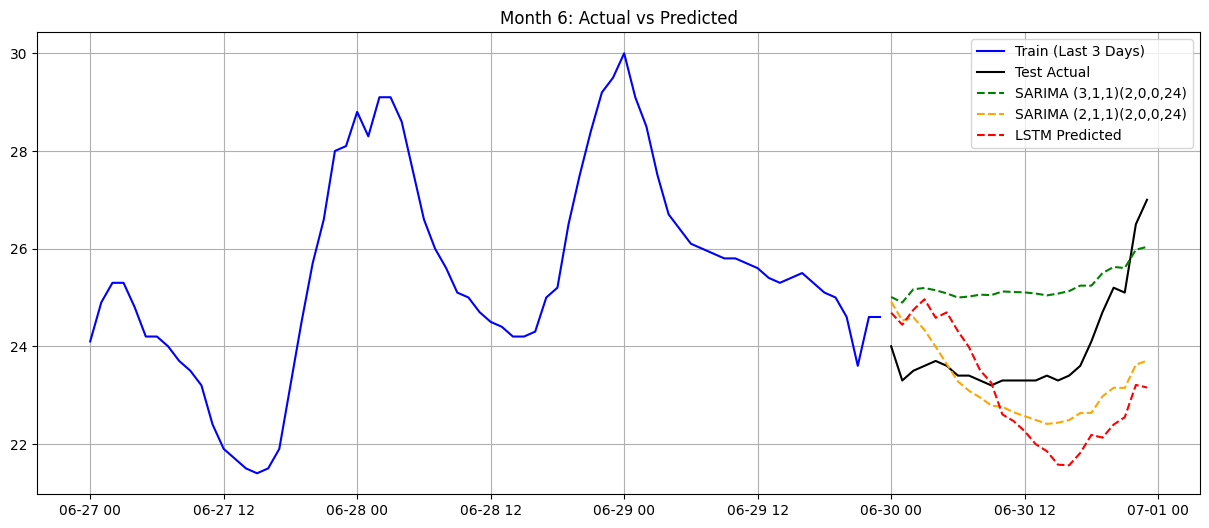

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Month 7 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 24.08 | AIC: 1074.56
  SARIMA (2,1,1)(2,0,0,24) - MSE: 24.00 | AIC: 1074.24
  LSTM                     - MSE: 3.67


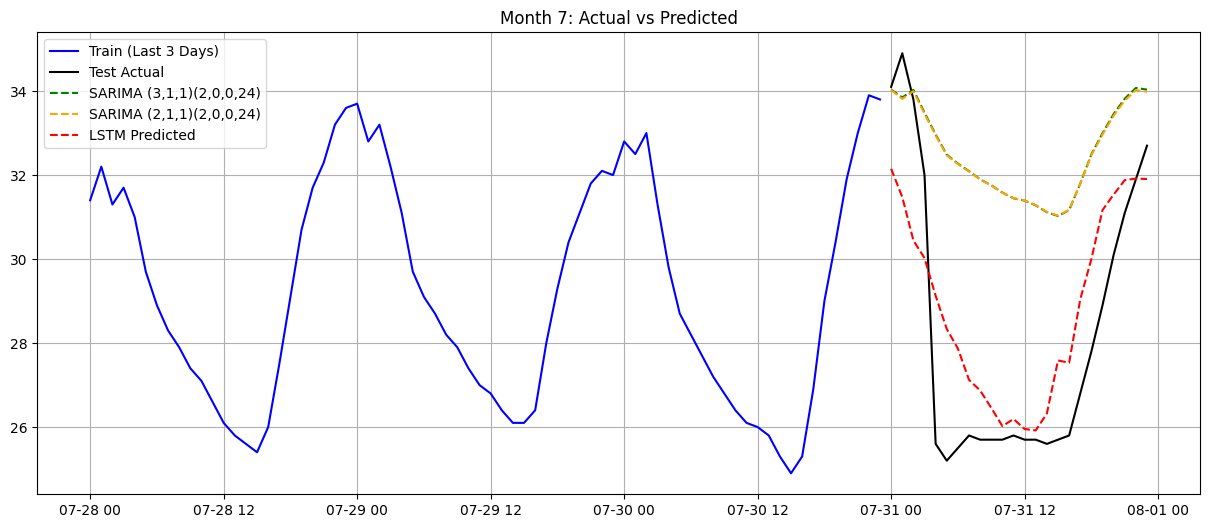

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

Month 8 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 4.45 | AIC: 1076.82
  SARIMA (2,1,1)(2,0,0,24) - MSE: 4.55 | AIC: 1077.67
  LSTM                     - MSE: 5.54


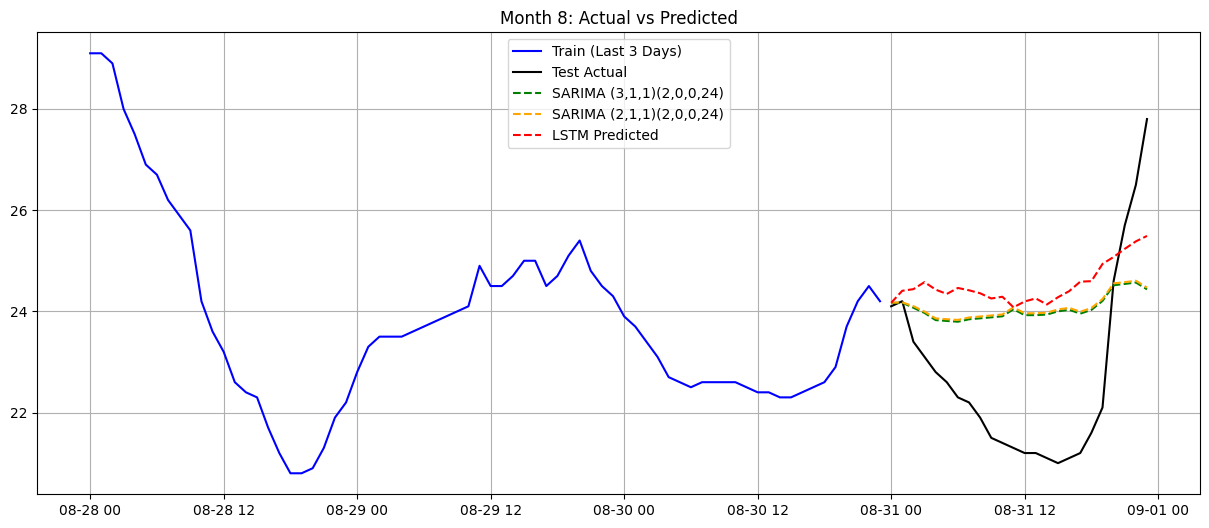

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

Month 9 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 5.14 | AIC: 715.29
  SARIMA (2,1,1)(2,0,0,24) - MSE: 20.29 | AIC: 767.43
  LSTM                     - MSE: 3.59


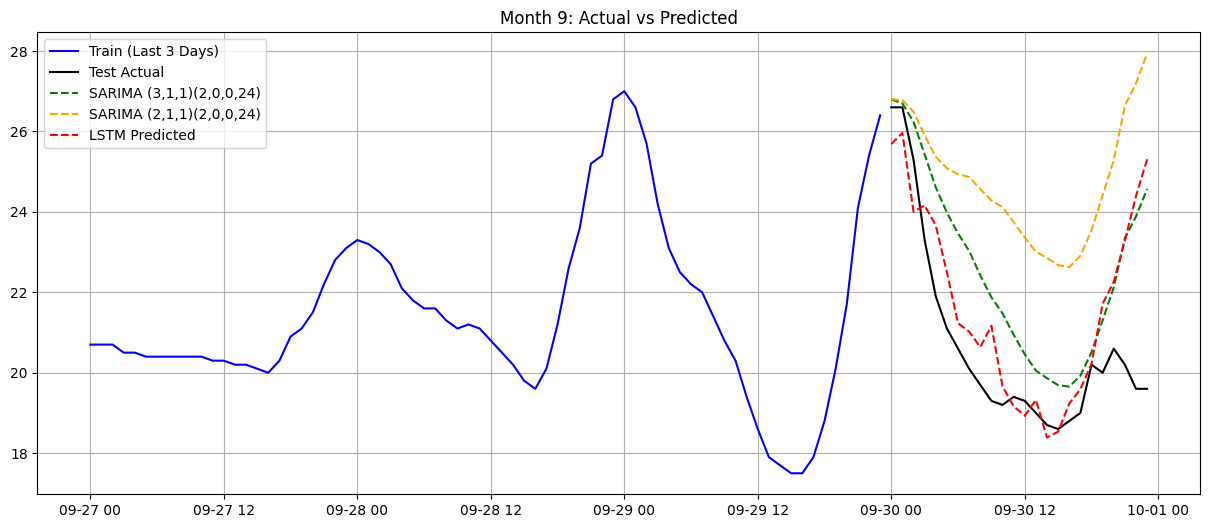

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

Month 10 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 0.56 | AIC: 1072.84
  SARIMA (2,1,1)(2,0,0,24) - MSE: 0.53 | AIC: 1072.41
  LSTM                     - MSE: 1.16


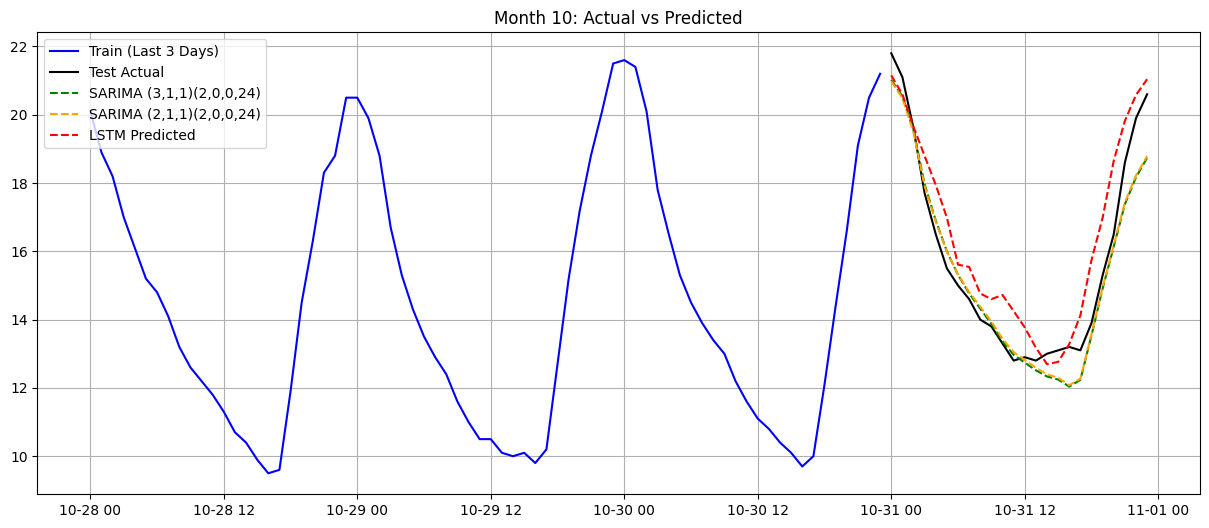

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Month 11 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 24.97 | AIC: 1132.14
  SARIMA (2,1,1)(2,0,0,24) - MSE: 28.31 | AIC: 1118.89
  LSTM                     - MSE: 37.49


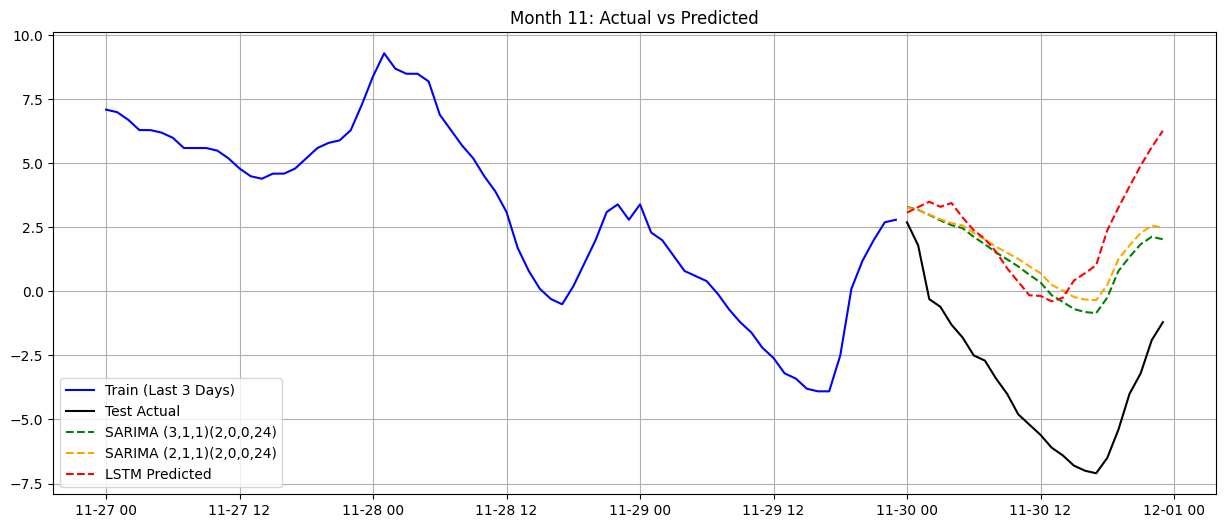

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Month 12 Performance:
  SARIMA (3,1,1)(2,0,0,24) - MSE: 5.17 | AIC: 1007.90
  SARIMA (2,1,1)(2,0,0,24) - MSE: 9.29 | AIC: 1023.34
  LSTM                     - MSE: 18.02


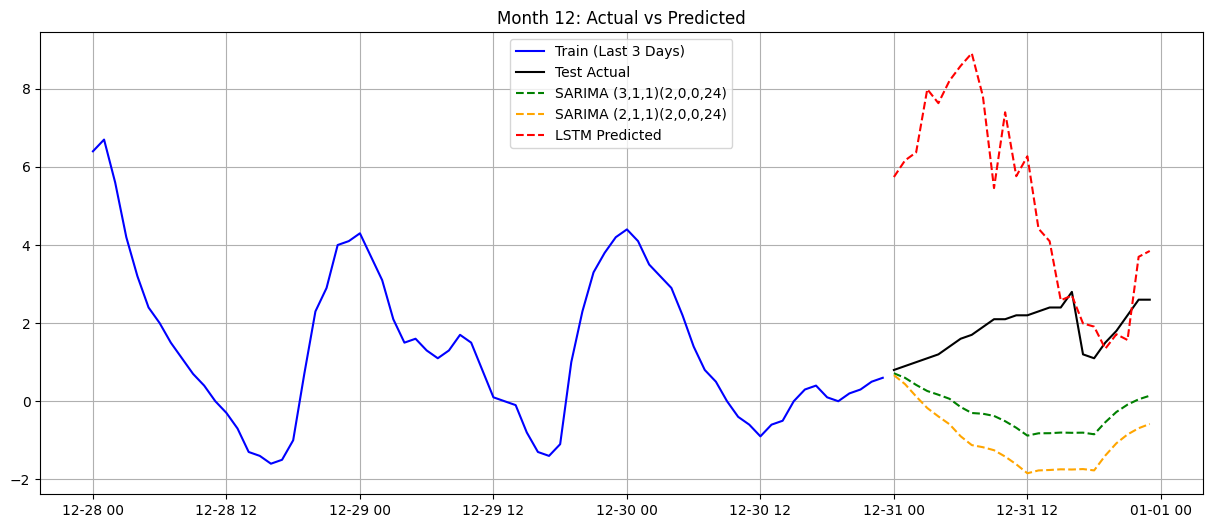

In [ ]:
mse_sarima_311_list = []
mse_sarima_211_list = []
mse_lstm_list = []
monthly_results = {}

for month in range(1, 13):
    month_data = df[df.index.month == month]
    train = month_data.iloc[:-24]['temp']
    test = month_data.iloc[-24 * 6:]['temp']

    sarima_311_pred, sarima_311_aic = sarimax_forecast(train, order=(3, 1, 1), seasonal_order=(2, 0, 0, 24))
    sarima_211_pred, sarima_211_aic = sarimax_forecast(train, order=(2, 1, 1), seasonal_order=(2, 0, 0, 24))
    lstm_pred = lstm_forecast(train.values, test.values)
    lstm_pred = lstm_pred.ravel()
    lstm_pred = pd.DataFrame(lstm_pred, columns=['Predicted'])

    test_actual = month_data.iloc[-24:]['temp']
    mse_sarima_311_list.append(mean_squared_error(test_actual, sarima_311_pred))
    mse_sarima_211_list.append(mean_squared_error(test_actual, sarima_211_pred))
    mse_lstm_list.append(mean_squared_error(test_actual, lstm_pred))
    monthly_results[month] = {
        'mse_sarima_311': mse_sarima_311,
        'mse_sarima_211': mse_sarima_211,
        'mse_lstm': mse_lstm,
    }
    print(f"\nMonth {month} Performance:")
    print(f"  SARIMA (3,1,1)(2,0,0,24) - MSE: {mse_sarima_311:.2f} | AIC: {sarima_311_aic:.2f}")
    print(f"  SARIMA (2,1,1)(2,0,0,24) - MSE: {mse_sarima_211:.2f} | AIC: {sarima_211_aic:.2f}")
    print(f"  LSTM                     - MSE: {mse_lstm:.2f}")

    plt.figure(figsize=(15, 6))
    train_last_3_days = train[-72:]
    plt.plot(train_last_3_days.index, train_last_3_days.values, label='Train (Last 3 Days)', color='blue')
    plt.plot(test_actual.index, test_actual.values, label='Test Actual', color='black')
    plt.plot(test_actual.index, sarima_311_pred, label='SARIMA (3,1,1)(2,0,0,24)', color='green', linestyle='--')
    plt.plot(test_actual.index, sarima_211_pred, label='SARIMA (2,1,1)(2,0,0,24)', color='orange', linestyle='--')
    plt.plot(test_actual.index, lstm_pred[:24], label='LSTM Predicted', color='red', linestyle='--')
    plt.title(f"Month {month}: Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# MSE 평균값 계산
avg_mse_sarima_311 = np.mean(mse_sarima_311_list)
avg_mse_sarima_211 = np.mean(mse_sarima_211_list)
avg_mse_lstm = np.mean(mse_lstm_list)

# 평균 MSE 출력
print("\nAverage MSE for Each Model:")
print(f"  SARIMA (3,1,1)(2,0,0,24): {avg_mse_sarima_311:.2f}")
print(f"  SARIMA (2,1,1)(2,0,0,24): {avg_mse_sarima_211:.2f}")
print(f"  LSTM                     : {avg_mse_lstm:.2f}")


Average MSE for Each Model:
  SARIMA (3,1,1)(2,0,0,24): 12.23
  SARIMA (2,1,1)(2,0,0,24): 14.22
  LSTM                     : 7.97
